In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as pn
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('customer_segmentation.csv', encoding = 'latin-1', parse_dates = ['InvoiceDate'])

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data = data.drop(['InvoiceNo', 'StockCode', 'Description', 'Country'], axis = 1)

In [5]:
data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID
0,6,2010-12-01 08:26:00,2.55,17850.0
1,6,2010-12-01 08:26:00,3.39,17850.0
2,8,2010-12-01 08:26:00,2.75,17850.0
3,6,2010-12-01 08:26:00,3.39,17850.0
4,6,2010-12-01 08:26:00,3.39,17850.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     541909 non-null  int64         
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   UnitPrice    541909 non-null  float64       
 3   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 16.5 MB


In [7]:
new_data = data.copy()
new_data = new_data.dropna()

In [8]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     406829 non-null  int64         
 1   InvoiceDate  406829 non-null  datetime64[ns]
 2   UnitPrice    406829 non-null  float64       
 3   CustomerID   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 15.5 MB


In [9]:
new_data['CustomerID'] = new_data['CustomerID'].astype(int)

In [10]:
new_data['InvoiceDate'] = new_data['InvoiceDate'].dt.normalize()

In [11]:
new_data['TotalSpend'] = new_data['Quantity'] * new_data['UnitPrice']

In [12]:
new_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalSpend
0,6,2010-12-01,2.55,17850,15.30
1,6,2010-12-01,3.39,17850,20.34
2,8,2010-12-01,2.75,17850,22.00
3,6,2010-12-01,3.39,17850,20.34
4,6,2010-12-01,3.39,17850,20.34


In [13]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     406829 non-null  int64         
 1   InvoiceDate  406829 non-null  datetime64[ns]
 2   UnitPrice    406829 non-null  float64       
 3   CustomerID   406829 non-null  int32         
 4   TotalSpend   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 17.1 MB


### Cohort Analysis

In [14]:
# Get range of initial purchases
first_purchase_df = new_data.sort_values(by = ['CustomerID', 'InvoiceDate']).groupby('CustomerID').first()

In [15]:
first_purchase_df

,Quantity,InvoiceDate,UnitPrice,TotalSpend
CustomerID,,,,
12346,74215,2011-01-18,1.04,77183.60
12347,12,2010-12-07,2.10,25.20
12348,72,2010-12-16,0.55,39.60
12349,2,2011-11-21,7.50,15.00
12350,12,2011-02-02,2.10,25.20
...,...,...,...,...
18280,3,2011-03-07,7.90,23.70
18281,12,2011-06-12,0.42,5.04
18282,1,2011-08-05,12.75,12.75


In [16]:
first_purchase_df.InvoiceDate.min()

Timestamp('2010-12-01 00:00:00')

In [17]:
first_purchase_df.InvoiceDate.max()

Timestamp('2011-12-09 00:00:00')

<Axes: xlabel='InvoiceDate'>

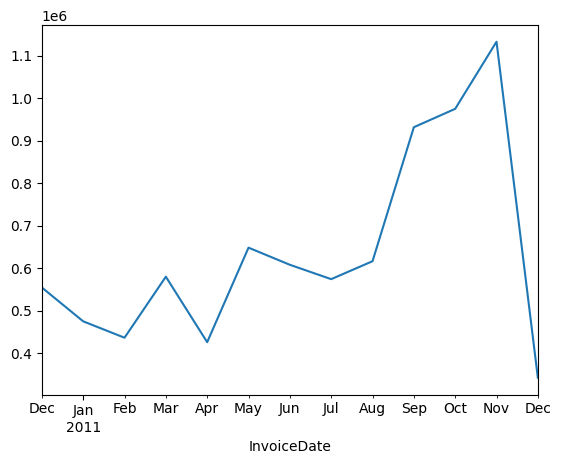

In [18]:
# Visualize purchases within cohort

new_data.reset_index().set_index('InvoiceDate')['TotalSpend'].resample(rule = 'MS').sum().plot()

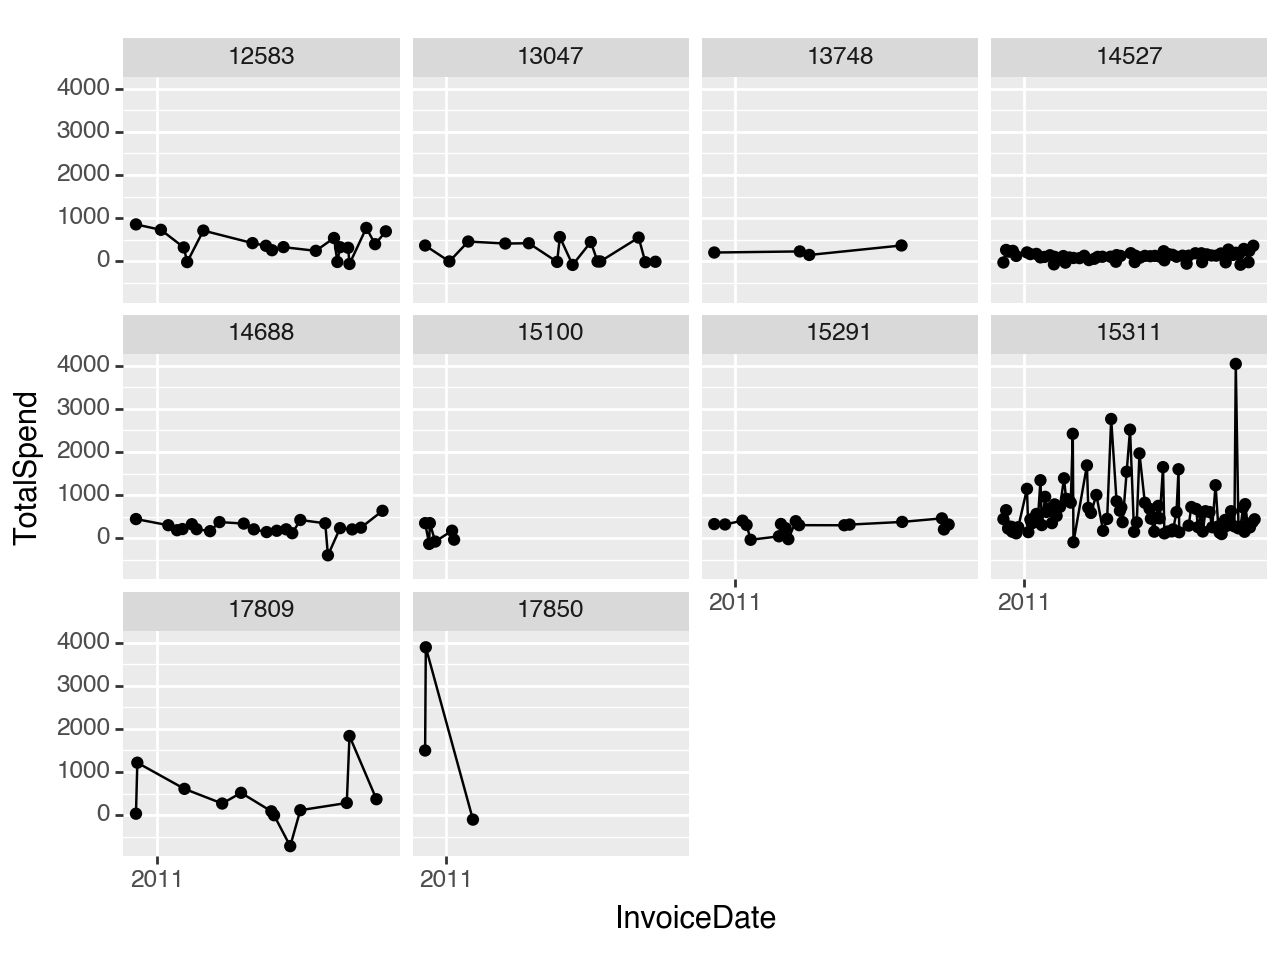

<Figure Size: (640 x 480)>

In [19]:
# Visualize individual customer purchases

ids = new_data['CustomerID'].unique()
ids_selected = ids[:10]

subset_df = new_data[new_data['CustomerID'].isin(ids_selected)].groupby(['CustomerID', 'InvoiceDate']).sum().reset_index()

pn.ggplot(subset_df, pn.aes('InvoiceDate', 'TotalSpend', group = 'CustomerID')) \
    + pn.geom_line() \
    + pn.geom_point() + pn.facet_wrap('CustomerID') + pn.scale_x_date(date_breaks = '1 year', date_labels = '%Y')

### Machine Learning
- What will the amount spent by the customers in the next 90-days?
- What is the probability of a customer to make a purchase in the next 90-days?

### Time splitting

In [20]:
n_days = 90
max_date = new_data['InvoiceDate'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd')

In [21]:
cutoff

Timestamp('2011-09-10 00:00:00')

In [22]:
in_timeframe_df = new_data[new_data['InvoiceDate'] <= cutoff]
out_timeframe_df = new_data[new_data['InvoiceDate'] > cutoff]

In [23]:
out_timeframe_df = out_timeframe_df.drop(['InvoiceDate'], axis = 1)
out_timeframe_df

,Quantity,UnitPrice,CustomerID,TotalSpend
334054,6,1.65,16899,9.90
334055,6,1.65,16899,9.90
334056,3,4.15,16899,12.45
334057,3,4.25,16899,12.75
334058,3,4.25,16899,12.75
...,...,...,...,...
541904,12,0.85,12680,10.20
541905,6,2.10,12680,12.60
541906,4,4.15,12680,16.60
541907,4,4.15,12680,16.60


### Feature Engineering

In [24]:
targets_df = out_timeframe_df.drop(['Quantity', 'UnitPrice'], axis = 1).groupby('CustomerID').sum().rename({'TotalSpend': 'total_spend_90'}, axis = 1).assign(flag_spend_90 = 1)

In [25]:
targets_df

,total_spend_90,flag_spend_90
CustomerID,,
12347,1519.14,1
12348,310.00,1
12349,1757.55,1
12352,944.23,1
12356,58.35,1
...,...,...
18277,110.38,1
18278,173.90,1
18282,77.84,1


In [26]:
max_date = in_timeframe_df['InvoiceDate'].max()

recency_points = in_timeframe_df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').apply(lambda x: (x['InvoiceDate'].max() - max_date) / pd.to_timedelta(1, 'day')).to_frame().set_axis(['recency'], axis = 1)

recency_points

,recency
CustomerID,
12346,-234.0
12347,-38.0
12348,-157.0
12350,-219.0
12352,-171.0
...,...
18280,-186.0
18281,-89.0
18282,-31.0


In [26]:
max_date

Timestamp('2011-09-09 00:00:00')

In [28]:
frequency_points = in_timeframe_df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').count().set_axis(['frequency'], axis = 1)

frequency_points

,frequency
CustomerID,
12346,2
12347,124
12348,28
12350,17
12352,48
...,...
18280,10
18281,7
18282,8


In [29]:
monetary_points = in_timeframe_df.groupby('CustomerID').aggregate({'TotalSpend': ['sum', 'mean']}).set_axis(['spend_sum', 'spend_average'], axis = 1)

monetary_points

,spend_sum,spend_average
CustomerID,,
12346,0.00,0.000000
12347,2790.86,22.506935
12348,1487.24,53.115714
12350,334.40,19.670588
12352,601.18,12.524583
...,...,...
18280,180.60,18.060000
18281,80.82,11.545714
18282,98.76,12.345000


In [30]:
features_df = pd.concat([recency_points, frequency_points, monetary_points], axis = 1).merge(targets_df, left_index = True, right_index=True, how = 'left').fillna(0)

features_df

,recency,frequency,spend_sum,spend_average,total_spend_90,flag_spend_90
CustomerID,,,,,,
12346,-234.0,2,0.00,0.000000,0.00,0.0
12347,-38.0,124,2790.86,22.506935,1519.14,1.0
12348,-157.0,28,1487.24,53.115714,310.00,1.0
12350,-219.0,17,334.40,19.670588,0.00,0.0
12352,-171.0,48,601.18,12.524583,944.23,1.0
...,...,...,...,...,...,...
18280,-186.0,10,180.60,18.060000,0.00,0.0
18281,-89.0,7,80.82,11.545714,0.00,0.0
18282,-31.0,8,98.76,12.345000,77.84,1.0


-0.7728439133195023
nan
0
0.3589008461121968


c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt


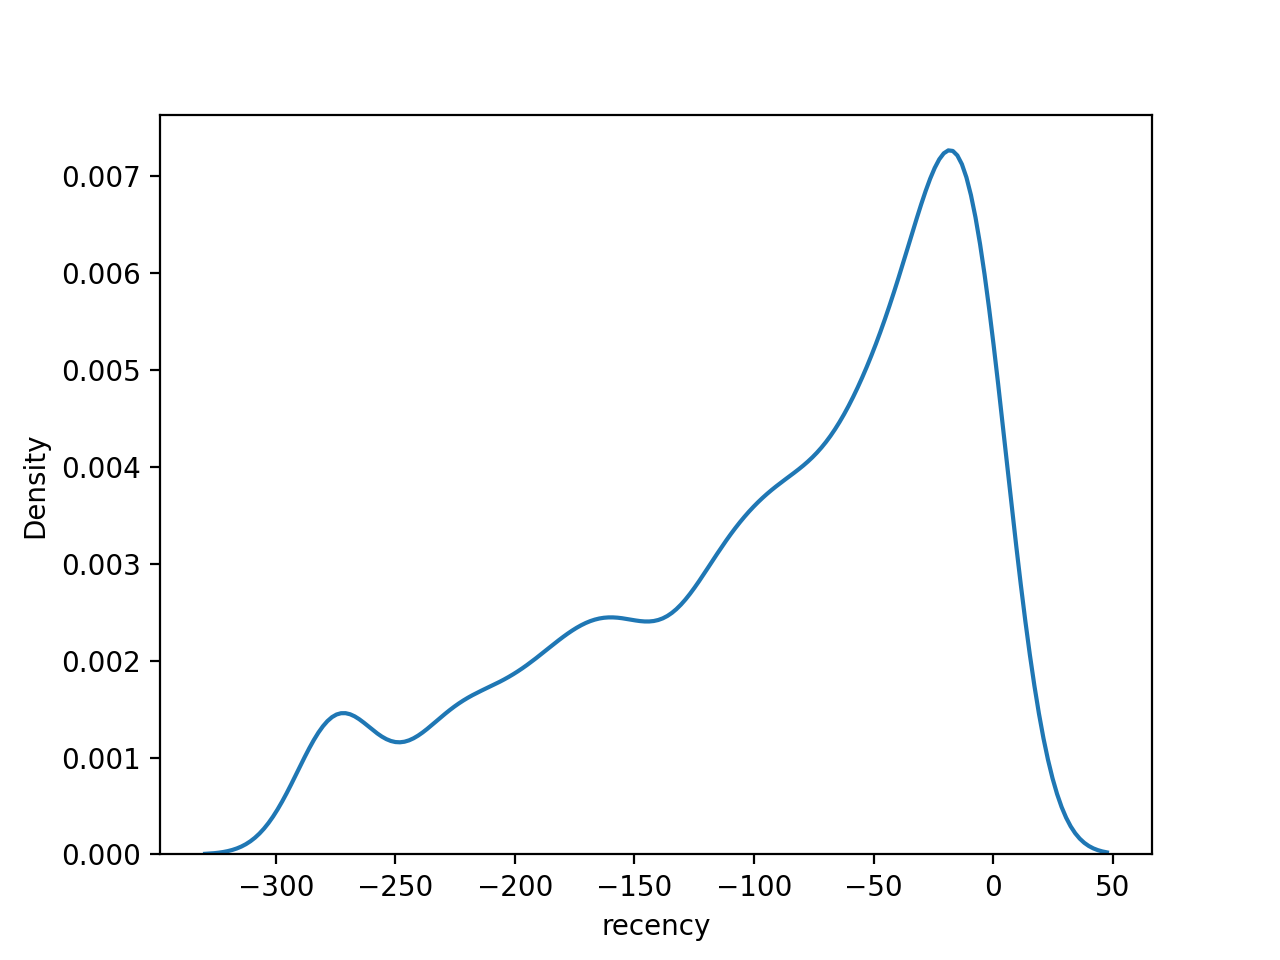

In [31]:
sns.kdeplot(features_df['recency'])
print(features_df['recency'].skew())
print(np.log(features_df['recency']).skew())
print(np.sqrt(features_df['recency']).skew())
print(np.cbrt(features_df['recency']).skew())

13.781039929078673
-0.2670186384063736
2.7096938763626457
1.3540299358850043


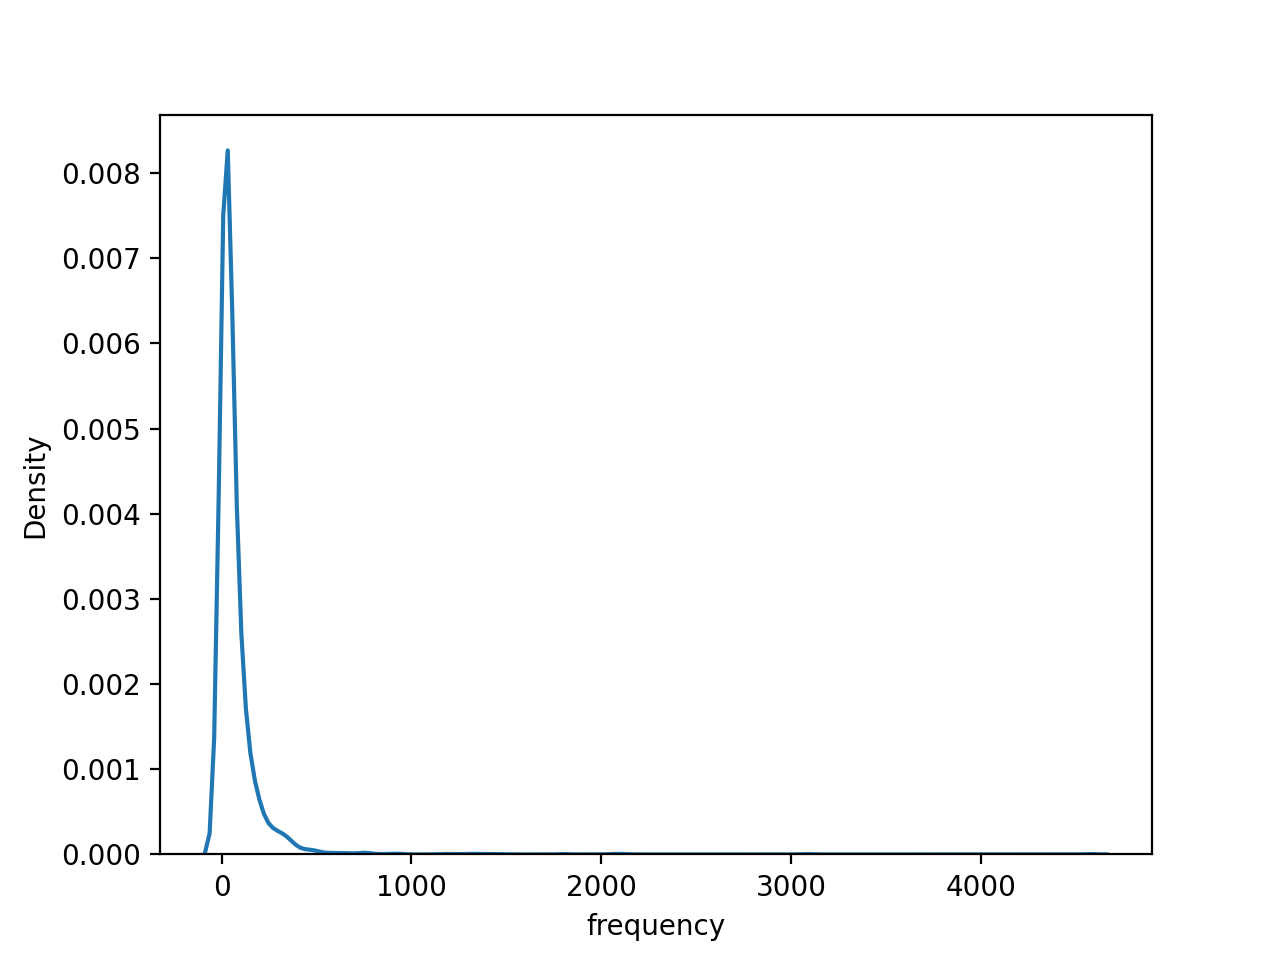

In [32]:
sns.kdeplot(features_df['frequency'])
print(features_df['frequency'].skew())
print(np.log(features_df['frequency']).skew())
print(np.sqrt(features_df['frequency']).skew())
print(np.cbrt(features_df['frequency']).skew())

17.77999044173552
nan
5.218797656896321
1.9253920558307185


c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt


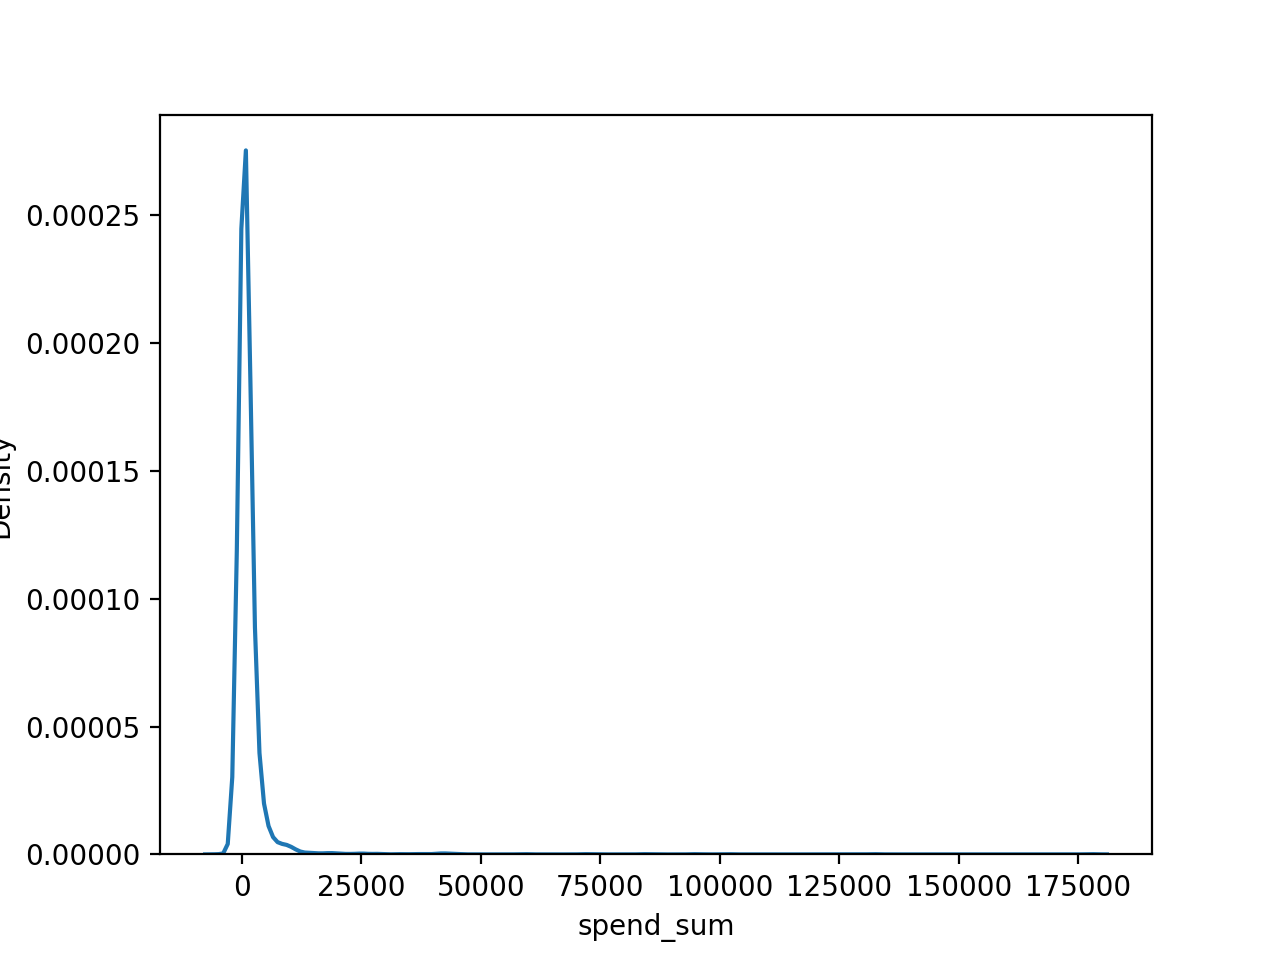

In [33]:
sns.kdeplot(features_df['spend_sum'])
print(features_df['spend_sum'].skew())
print(np.log(features_df['spend_sum']).skew())
print(np.sqrt(features_df['spend_sum']).skew())
print(np.cbrt(features_df['spend_sum']).skew())

-8.191770522763239
nan
5.1795717561648456
-1.6509476941755934


c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt


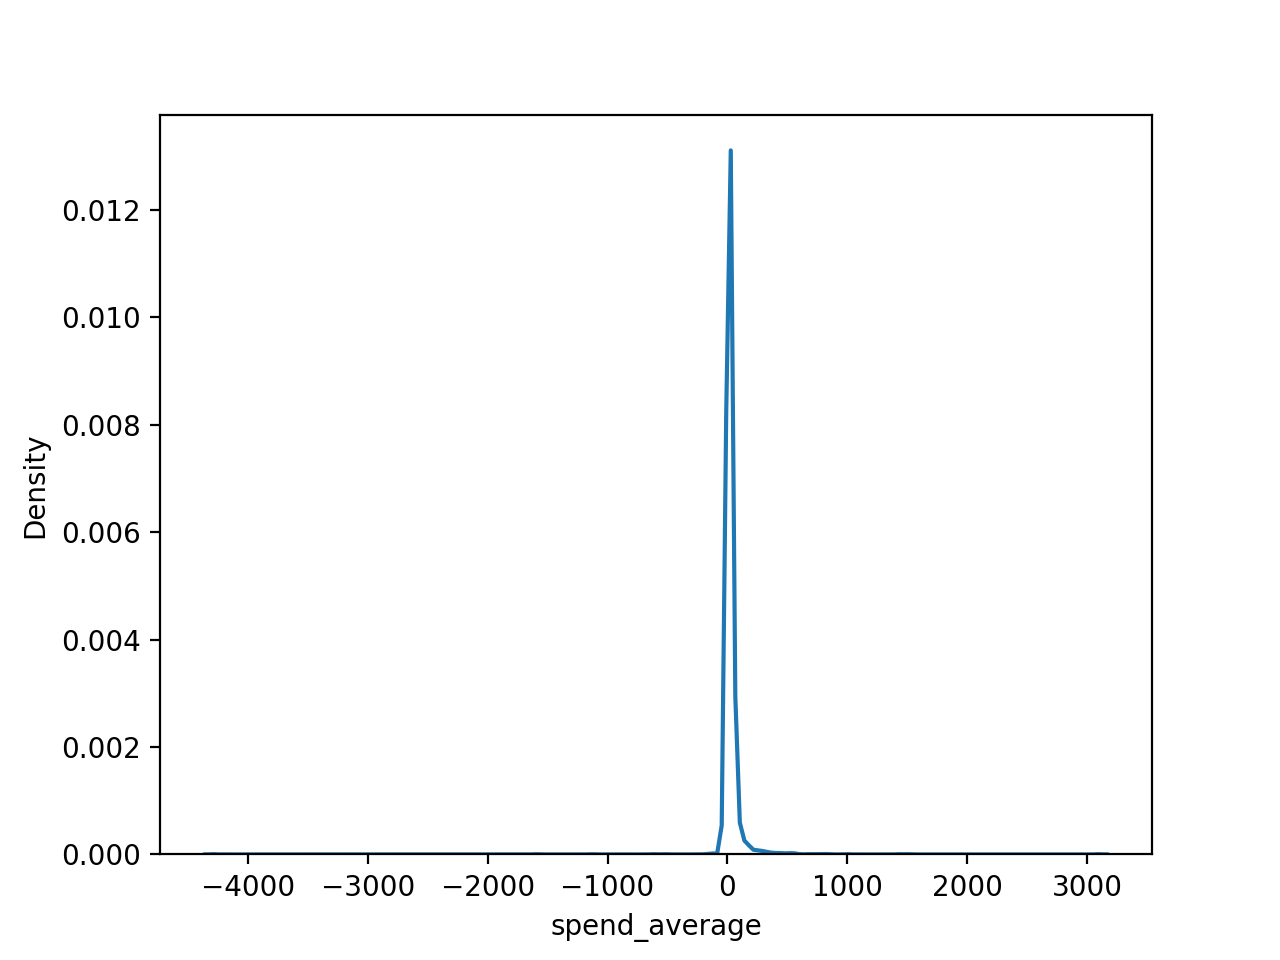

In [34]:
sns.kdeplot(features_df['spend_average'])
print(features_df['spend_average'].skew())
print(np.log(features_df['spend_average']).skew())
print(np.sqrt(features_df['spend_average']).skew())
print(np.cbrt(features_df['spend_average']).skew())

21.775993849600567
nan
4.5054956723600865
1.1871851625185137


c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
c:\Users\dinhd\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt


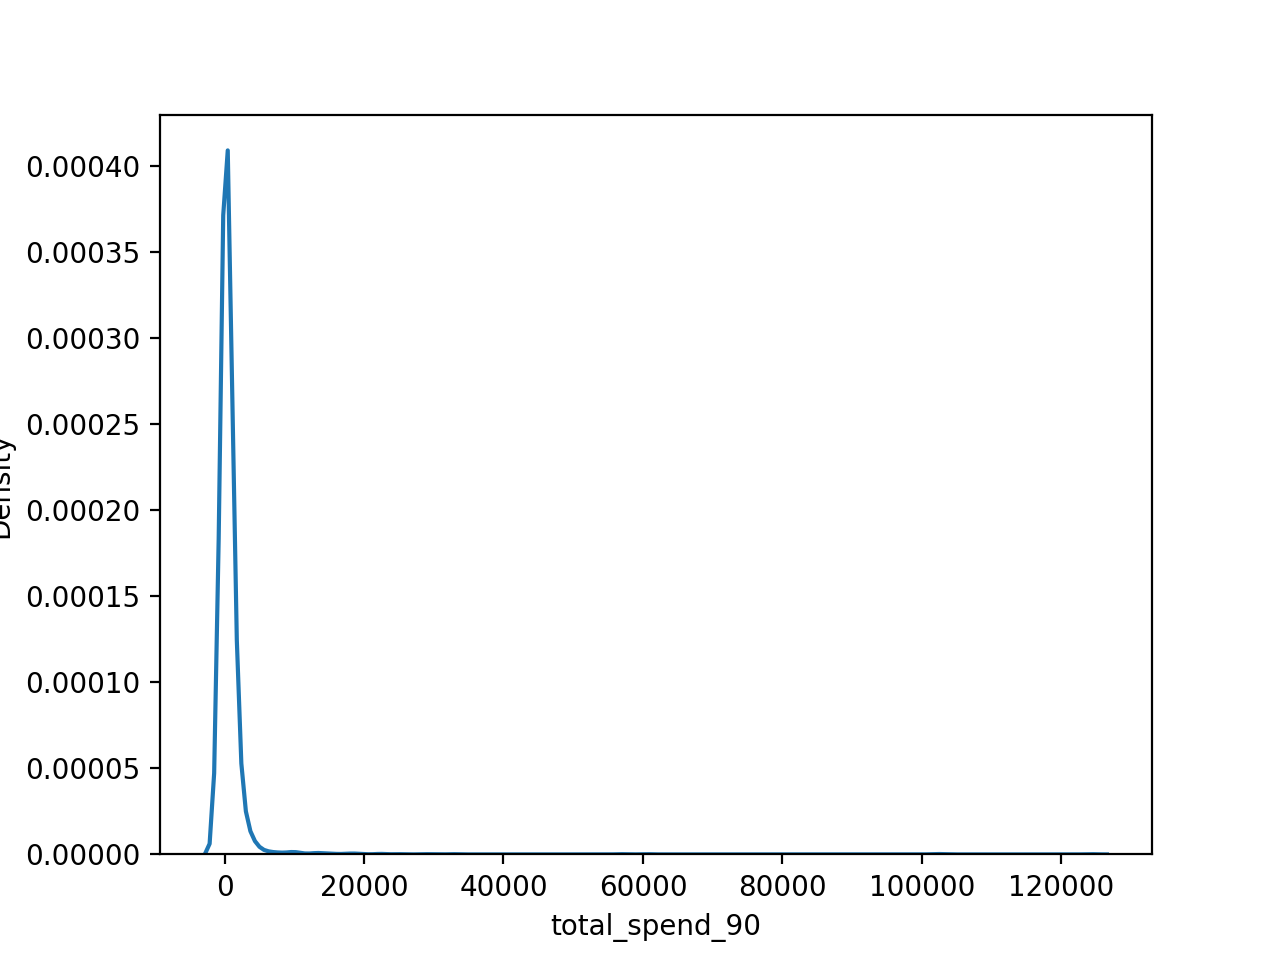

In [35]:
sns.kdeplot(features_df['total_spend_90'])
print(features_df['total_spend_90'].skew())
print(np.log(features_df['total_spend_90']).skew())
print(np.sqrt(features_df['total_spend_90']).skew())
print(np.cbrt(features_df['total_spend_90']).skew())

In [36]:
features_df['recency_cbrt'] = np.cbrt(features_df['recency'])

In [37]:
features_df['frequency_log'] = np.log(features_df['frequency'])

In [38]:
features_df['spend_sum_cbrt'] = np.cbrt(features_df['spend_sum'])
features_df['spend_average_cbrt'] = np.cbrt(features_df['spend_average'])
features_df['total_spend_90_cbrt'] = np.cbrt(features_df['total_spend_90'])

In [39]:
features_df

,recency,frequency,spend_sum,spend_average,total_spend_90,flag_spend_90,recency_cbrt,frequency_log,spend_sum_cbrt,spend_average_cbrt,total_spend_90_cbrt
CustomerID,,,,,,,,,,,
12346,-234.0,2,0.00,0.000000,0.00,0.0,-6.162240,0.693147,0.000000,0.000000,0.000000
12347,-38.0,124,2790.86,22.506935,1519.14,1.0,-3.361975,4.820282,14.079244,2.823398,11.495625
12348,-157.0,28,1487.24,53.115714,310.00,1.0,-5.394691,3.332205,11.414591,3.759017,6.767899
12350,-219.0,17,334.40,19.670588,0.00,0.0,-6.027650,2.833213,6.941001,2.699432,0.000000
12352,-171.0,48,601.18,12.524583,944.23,1.0,-5.550499,3.871201,8.439852,2.322315,9.810533
...,...,...,...,...,...,...,...,...,...,...,...
18280,-186.0,10,180.60,18.060000,0.00,0.0,-5.708267,2.302585,5.652483,2.623650,0.000000
18281,-89.0,7,80.82,11.545714,0.00,0.0,-4.464745,1.945910,4.323541,2.260166,0.000000
18282,-31.0,8,98.76,12.345000,77.84,1.0,-3.141381,2.079442,4.622324,2.311162,4.269735


In [40]:
transformed_features = features_df.drop(['recency', 'frequency', 'spend_sum', 'spend_average', 'total_spend_90'], axis = 1)

In [41]:
transformed_features

,flag_spend_90,recency_cbrt,frequency_log,spend_sum_cbrt,spend_average_cbrt,total_spend_90_cbrt
CustomerID,,,,,,
12346,0.0,-6.162240,0.693147,0.000000,0.000000,0.000000
12347,1.0,-3.361975,4.820282,14.079244,2.823398,11.495625
12348,1.0,-5.394691,3.332205,11.414591,3.759017,6.767899
12350,0.0,-6.027650,2.833213,6.941001,2.699432,0.000000
12352,1.0,-5.550499,3.871201,8.439852,2.322315,9.810533
...,...,...,...,...,...,...
18280,0.0,-5.708267,2.302585,5.652483,2.623650,0.000000
18281,0.0,-4.464745,1.945910,4.323541,2.260166,0.000000
18282,1.0,-3.141381,2.079442,4.622324,2.311162,4.269735


### Building model

In [65]:
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    RepeatedKFold,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

X = transformed_features[
    ["recency_cbrt", "frequency_log", "spend_sum_cbrt", "spend_average_cbrt"]
]
y = transformed_features["total_spend_90_cbrt"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.array(y).reshape(-1, 1))

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state = 2002)

model_xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=2002)

model_xgb_reg_tuned = GridSearchCV(
    estimator=model_xgb_reg,
    param_grid=dict(
        n_estimators = [100, 200, 500],
        learning_rate=[0.01, 0.1, 0.2],
        max_depth=range(3, 6),
        subsample=[0.8],
        colsample_bytree=[0.8],
    ),
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=cv,
    verbose=5,
)

model_xgb_reg_tuned.fit(X_scaled, y_scaled)
best_estimator_xgb_reg = model_xgb_reg_tuned.best_estimator_
print(best_estimator_xgb_reg)
print(best_estimator_xgb_reg.score(X_scaled, y_scaled))

Fitting 30 folds for each of 27 candidates, totalling 810 fits
[CV 1/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.746 total time=   0.0s
[CV 2/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.674 total time=   0.0s
[CV 3/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.691 total time=   0.0s
[CV 4/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.719 total time=   0.0s
[CV 5/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.713 total time=   0.0s
[CV 6/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.714 total time=   0.0s
[CV 7/30] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-0.687 total time=

In [66]:
y_pred = best_estimator_xgb_reg.predict(X_scaled)

In [67]:
inverse_prediction = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [68]:
inverse_prediction = np.power(inverse_prediction, 3)

In [69]:
len(inverse_prediction)

3412

In [73]:
### Next 90-days spend probability
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

X = features_df[["recency", "frequency", "spend_sum", "spend_average"]]
y_prob = transformed_features["flag_spend_90"]
# y_prob_scaled = scaler.fit_transform(np.array(y_prob).reshape(-1, 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_prob, test_size = 0.2, random_state = 2002)


model_xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic", random_state=2002, n_estimators=300
)

model_xgb_clf_tuned = GridSearchCV(
    estimator=model_xgb_clf,
    param_grid=dict(
        learning_rate=[0.01, 0.1, 0.3],
        max_depth=[3, 4, 5],
        min_child_weight = [4, 5, 6]
    ),
    scoring="roc_auc",
    refit=True,
    cv=5,
    verbose=5
)
model_xgb_clf_tuned.fit(X_scaled, y_prob)
best_est_xgb_clf = model_xgb_clf_tuned.best_estimator_
print(best_est_xgb_clf)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, min_child_weight=4;, score=0.767 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_child_weight=4;, score=0.734 total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_child_weight=4;, score=0.748 total time=   0.4s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_child_weight=4;, score=0.753 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_child_weight=4;, score=0.738 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_child_weight=5;, score=0.767 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_child_weight=5;, score=0.734 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_child_weight=5;, score=0.746 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_child_weight=5;, score=0.751 total time=   0.4s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_child_

In [74]:
prediction_clf = best_est_xgb_clf.predict_proba(X_scaled)

In [75]:
prediction_clf

array([[0.63968533, 0.36031467],
       [0.1390453 , 0.8609547 ],
       [0.49010277, 0.50989723],
       ...,
       [0.5715871 , 0.42841294],
       [0.15172547, 0.8482745 ],
       [0.40549356, 0.59450644]], dtype=float32)

In [76]:
prediction_df = features_df.drop(features_df.iloc[:, 6:], axis = 1)

In [77]:
prediction_df

,recency,frequency,spend_sum,spend_average,total_spend_90,flag_spend_90
CustomerID,,,,,,
12346,-234.0,2,0.00,0.000000,0.00,0.0
12347,-38.0,124,2790.86,22.506935,1519.14,1.0
12348,-157.0,28,1487.24,53.115714,310.00,1.0
12350,-219.0,17,334.40,19.670588,0.00,0.0
12352,-171.0,48,601.18,12.524583,944.23,1.0
...,...,...,...,...,...,...
18280,-186.0,10,180.60,18.060000,0.00,0.0
18281,-89.0,7,80.82,11.545714,0.00,0.0
18282,-31.0,8,98.76,12.345000,77.84,1.0


In [78]:
pd.DataFrame(inverse_prediction).set_axis(['pred_spend'], axis = 1)

,pred_spend
0,5.704307
1,822.167969
2,87.300751
3,15.632449
4,37.787060
...,...
3407,8.669845
3408,11.279131
3409,14.868492
3410,502.169403


In [79]:
pd.DataFrame(prediction_clf)[[1]].set_axis(['pred_prob'], axis = 1)

,pred_prob
0,0.360315
1,0.860955
2,0.509897
3,0.340300
4,0.445181
...,...
3407,0.321786
3408,0.393473
3409,0.428413
3410,0.848275


In [80]:
prediction_df = pd.concat([
    pd.DataFrame(inverse_prediction).set_axis(['pred_spend'], axis = 1),
    pd.DataFrame(prediction_clf)[[1]].set_axis(['pred_prob'], axis = 1),
    prediction_df.reset_index()
], axis = 1)

In [81]:
prediction_df['spend_actual_vs_pred'] = (prediction_df['total_spend_90'] - prediction_df['pred_spend'])

In [82]:
prediction_df

,pred_spend,pred_prob,CustomerID,recency,frequency,spend_sum,spend_average,total_spend_90,flag_spend_90,spend_actual_vs_pred
0,5.704307,0.360315,12346,-234.0,2,0.00,0.000000,0.00,0.0,-5.704307
1,822.167969,0.860955,12347,-38.0,124,2790.86,22.506935,1519.14,1.0,696.972031
2,87.300751,0.509897,12348,-157.0,28,1487.24,53.115714,310.00,1.0,222.699249
3,15.632449,0.340300,12350,-219.0,17,334.40,19.670588,0.00,0.0,-15.632449
4,37.787060,0.445181,12352,-171.0,48,601.18,12.524583,944.23,1.0,906.442940
...,...,...,...,...,...,...,...,...,...,...
3407,8.669845,0.321786,18280,-186.0,10,180.60,18.060000,0.00,0.0,-8.669845
3408,11.279131,0.393473,18281,-89.0,7,80.82,11.545714,0.00,0.0,-11.279131
3409,14.868492,0.428413,18282,-31.0,8,98.76,12.345000,77.84,1.0,62.971508
3410,502.169403,0.848275,18283,-4.0,447,1120.67,2.507092,974.21,1.0,472.040597


In [83]:
prediction_df = prediction_df.rename(columns = {'frequency': 'Purchase Frequency', 'total_spend_90': 'Actual Amount Spent',
'pred_spend': 'Predicted Amount Spent', 'pred_prob': 'Predicted Purchasing Probability', 'spend_actual_vs_pred': 'Actual vs Predicted Amount Difference'})

In [84]:
prediction_df

,Predicted Amount Spent,Predicted Purchasing Probability,CustomerID,recency,Purchase Frequency,spend_sum,spend_average,Actual Amount Spent,flag_spend_90,Actual vs Predicted Amount Difference
0,5.704307,0.360315,12346,-234.0,2,0.00,0.000000,0.00,0.0,-5.704307
1,822.167969,0.860955,12347,-38.0,124,2790.86,22.506935,1519.14,1.0,696.972031
2,87.300751,0.509897,12348,-157.0,28,1487.24,53.115714,310.00,1.0,222.699249
3,15.632449,0.340300,12350,-219.0,17,334.40,19.670588,0.00,0.0,-15.632449
4,37.787060,0.445181,12352,-171.0,48,601.18,12.524583,944.23,1.0,906.442940
...,...,...,...,...,...,...,...,...,...,...
3407,8.669845,0.321786,18280,-186.0,10,180.60,18.060000,0.00,0.0,-8.669845
3408,11.279131,0.393473,18281,-89.0,7,80.82,11.545714,0.00,0.0,-11.279131
3409,14.868492,0.428413,18282,-31.0,8,98.76,12.345000,77.84,1.0,62.971508
3410,502.169403,0.848275,18283,-4.0,447,1120.67,2.507092,974.21,1.0,472.040597


In [85]:
prediction_df.to_csv('prediction.csv', index = None)